# 1 Autoencoder

A convolutional autoencoder is a particular 
avor of autoencoder where we
use convolutional layers instead of dense layers. We have previously applied
autoencoders to images using only Dense layers and the result worked fairly
well. However, the local spatial correlations of images imply that we should be
able to do better using convolutional layers instead of Dense layers.

Build and fit a convolutional autoencoder for the Fashion MNIST dataset.
The components of this network will be many of the same pieces we've used
with convolutional classification networks: Conv2D, MaxPooling, and so on.
The encoder part of the network should run the input image through a few
convolutional layers of your choice. The decoder part of the network will utilize
UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html.

After training your network, visualize some examples of input images and
their decoded reconstruction.

In [7]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Conv1D,Conv2D,GlobalMaxPooling1D, MaxPooling2D, UpSampling2D,Dropout,Flatten, Embedding, LSTM
from keras.models import Model,Sequential
from keras import backend as K
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import np_utils  
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adam, RMSprop

from keras.preprocessing.text import Tokenizer
from string import printable
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import regularizers
from bs4 import BeautifulSoup
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import class_weight, shuffle
from tokenize import tokenize

### Data Preperation

In [0]:
# Load fashion mnist data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# reshape data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Train the Autoencoder

In [0]:
# Add Layers from the blog
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [0]:
#from keras.callbacks import TensorBoard
auto_encoder_result = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.3728 - val_loss: 0.3340
Epoch 2/20
60000/60000 [==============================] - 7s 109us/step - loss: 0.3241 - val_loss: 0.3211
Epoch 3/20
60000/60000 [==============================] - 7s 110us/step - loss: 0.3143 - val_loss: 0.3148
Epoch 4/20
60000/60000 [==============================] - 7s 109us/step - loss: 0.3075 - val_loss: 0.3205
Epoch 5/20
60000/60000 [==============================] - 7s 109us/step - loss: 0.3030 - val_loss: 0.3030
Epoch 6/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.3007 - val_loss: 0.3000
Epoch 7/20
60000/60000 [==============================] - 7s 109us/step - loss: 0.2988 - val_loss: 0.3013
Epoch 8/20
60000/60000 [==============================] - 7s 110us/step - loss: 0.2969 - val_loss: 0.2982
Epoch 9/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.2958 - val_loss: 0.

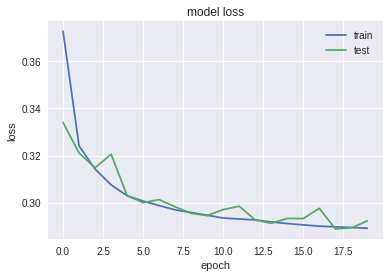

In [0]:
# Visualize the loss
def loss_plot(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

loss_plot(auto_encoder_result)

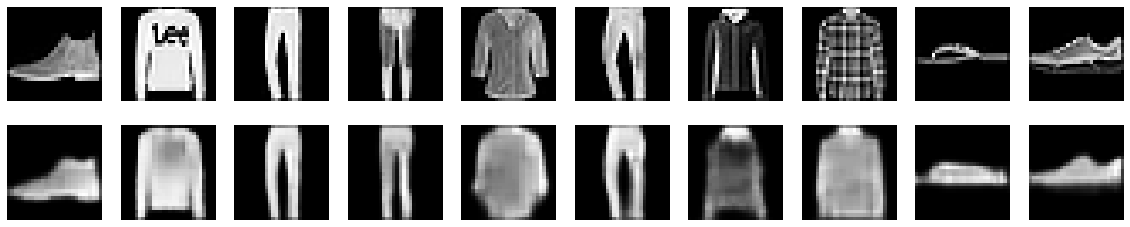

In [0]:
#decode image and visualize
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

From above result, we can see that the test loss and the train loss are similar and the structure of the ouput picture is still recognizable.

# 2 Image Classification

We'll continue to use the Fashion MNIST dataset and build a deep convolutional
network for classification.

## 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you've made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model's performance on training
set and test set.

### Data Preperation

In [0]:
# Load fashion mnist data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# reshape data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

# make a categorical clothing type
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Add Layers



In [0]:
model = Sequential()

model.add(Conv2D(filters = 64,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))


model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                102464    
__________

In [0]:
model_training = model.fit(x_train,
                             y_train,
                             batch_size=128,
                             epochs=30,
                             validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 137us/step - loss: 0.7417 - acc: 0.7317 - val_loss: 0.4370 - val_acc: 0.8349
Epoch 2/30
60000/60000 [==============================] - 7s 119us/step - loss: 0.4759 - acc: 0.8298 - val_loss: 0.3550 - val_acc: 0.8713
Epoch 3/30
60000/60000 [==============================] - 7s 119us/step - loss: 0.4183 - acc: 0.8506 - val_loss: 0.3376 - val_acc: 0.8743
Epoch 4/30
60000/60000 [==============================] - 7s 120us/step - loss: 0.3846 - acc: 0.8624 - val_loss: 0.3130 - val_acc: 0.8839
Epoch 5/30
60000/60000 [==============================] - 7s 122us/step - loss: 0.3618 - acc: 0.8709 - val_loss: 0.2983 - val_acc: 0.8902
Epoch 6/30
60000/60000 [==============================] - 7s 121us/step - loss: 0.3425 - acc: 0.8762 - val_loss: 0.2904 - val_acc: 0.8900
Epoch 7/30
60000/60000 [==============================] - 7s 119us/step - loss: 0.3228 - acc: 0.8836 - val_loss: 0.2912 - 

60000/60000 [==============================] - 6s 102us/step
[0.24062041827738284, 0.9135]
[0.1231060484106342, 0.9525666666666667]


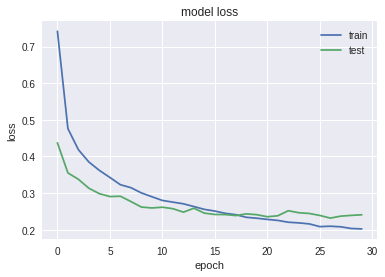

In [0]:
# Evaluate and Plot history

test_score = model.evaluate(x_test, y_test)
train_score = model.evaluate(x_train, y_train)
print(test_score)
print(train_score)
loss_plot(model_training)

Here, I chosed a network with two convolutional layers with 64 filters, kernel_size = (3,3), strides = (1,1) and chosed padding = "valid". Also with a dense layer of size 64.  

From the above result, the model achieved an 91.35% accuracy on test data after 30 epochs and the loss is around 0.24. Also, the model achieved a 95.25% accuracy and 0.12 loss on train data.

## 2.2 Trasfer Learning

Repeat the same task, but this time utilize a pre-trained network for the major-
ity of your model. You should only train the final Dense layer, all other weights
should be fixed. You can use whichever pre-trained backbone you like (ResNet,
VGG, etc). Report on your model's performance on training set and test set.

### Data Prep

In [0]:
# Load fashion mnist data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# reshape data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

# make a categorical clothing type
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)


x_train_tl = np.asarray([cv2.resize(x, (48,48)) for x in x_train])
x_test_tl = np.asarray([cv2.resize(x, (48,48)) for x in x_test])

x_train_tl = x_train_tl.reshape(x_train_tl.shape[0], 48, 48,1)
x_test_tl  = x_test_tl.reshape(x_test_tl.shape[0], 48, 48, 1)

# make gray images into rgb images
x_train_tl = x_train_tl.repeat(3, axis=-1)
x_test_tl  = x_test_tl.repeat(3, axis=-1)

print(x_train_tl.shape)
print(x_test_tl.shape)


(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 48, 48, 3)
(10000, 48, 48, 3)


In [0]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(48,48,3))

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_34 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["acc"])

tl_model = model.fit(x_train_tl, 
          y_train,
          batch_size=128,
          shuffle=True,
          epochs=15, 
          validation_data=(x_test_tl, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 42s 708us/step - loss: 0.5586 - acc: 0.8095 - val_loss: 0.4310 - val_acc: 0.8462
Epoch 2/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3958 - acc: 0.8574 - val_loss: 0.3966 - val_acc: 0.8592
Epoch 3/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3627 - acc: 0.8684 - val_loss: 0.3912 - val_acc: 0.8576
Epoch 4/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3431 - acc: 0.8740 - val_loss: 0.3749 - val_acc: 0.8673
Epoch 5/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3268 - acc: 0.8800 - val_loss: 0.3665 - val_acc: 0.8696
Epoch 6/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3152 - acc: 0.8849 - val_loss: 0.3545 - val_acc: 0.8761
Epoch 7/15
60000/60000 [==============================] - 41s 680us/step - loss: 0.3003 - acc: 0.8904 - val_loss: 0.

In [0]:
# Evaluate the model 
score_test = model.evaluate(x_test_tl, y_test, verbose=0)
print("Test: ",score_test)
score_train = model.evaluate(x_train_tl, y_train, verbose=0)
print("Train: ",score_train)

Test:  [0.33409591370821, 0.8859]
Train:  [0.2104995892037948, 0.9241333333333334]


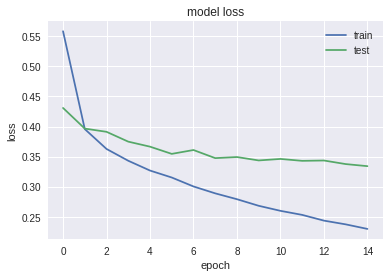

In [0]:
loss_plot(tl_model)

Here I choosed to use the VGG pre-trained backbone. With a final dense layer of size 256, the model achieved an accuracy about 88.59% and 0.33 loss on test set. The accuracy and loss on train set is around 92.4% and 0.21. Compare to the deep CNN model, the result is not as good as the deep CNN model.

# 3 Text Classification

While images contain local spatial correlations and structure, many other datasets
contain temporal correlations. Examples include time series and discrete se-
quences such as text. In this problem, we will tackle the task of text classica-
tion in the context of natural language.

Background. In this problem, we will build models that read short text
segments (tweets) and identify if one or more specific topics are being discussed.
Dataset. The dataset consists of tweets along with labels for which topics
were being referenced in the tweet. Examples of the topics include "storms",
"rain", "hurricane", "snow" and so on. Unlike previous classification problems
we have encountered, in this dataset, there is not just a single right answer.
The labels here are derived from multiple annotators decided how to label each
tweet, so a single tweet can be about more than one topic. The label is the
fraction of annotations for a given topic, and each row should sum to 1.
What Loss function should you use here? Categorical CrossEntropy might
work, but with some modification since we don't have "hard" labels over the
categories. Another option might be sigmoid: for each output category, use a
sigmoid to collapse the output to between 0 and 1, but each category output
can be roughly independent of the others. In the problems below, feel free to
try both.

## 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classication task.
You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

### Data Prep

In [3]:
tweets = pd.read_csv("tweets_with_labels.csv",sep ="\t")
tweets.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [8]:
def review_to_words(raw_review):
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    # 4. In Python, searching a set is much faster than searching
    return( " ".join(words)) 

In [9]:
tweets['tweet'] = tweets['tweet'].apply(review_to_words)
X = tweets['tweet']
y = tweets.drop(['id','tweet'],axis = 1).values

In [10]:
# split test and train set
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=30)
#Shuffle data to get training and validation dataset for further use
X_train_shuf, y_train_shuf = shuffle(x_train, y_train, random_state=30)
X_train, X_valid, y_train,y_valid = train_test_split(X_train_shuf,y_train_shuf,test_size = 0.20, random_state = 30)
print(X_train.shape,y_train.shape)
print(X_valid.shape, y_valid.shape)
print(x_test.shape,y_test.shape)

(49884,) (49884, 15)
(12472,) (12472, 15)
(15590,) (15590, 15)


In [11]:
MAX_NUM_WORDS = 500 
MAX_SEQUENCE_LENGTH = 50 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train) 
valid_sequences = tokenizer.texts_to_sequences(X_valid)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [12]:
text_train_2 = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH)
text_valid_2 = pad_sequences(valid_sequences,maxlen=MAX_SEQUENCE_LENGTH)
text_test_2 = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
model_RNN = Sequential()
model_RNN.add(Embedding(MAX_NUM_WORDS, 64))
#model.add(SimpleRNN(32))
#model.add(GRU(32))
model_RNN.add(LSTM(32))
model_RNN.add(Dense(15, activation ='softmax'))
model_RNN.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['acc'])
rnn_history = model_RNN.fit(text_train_2, y_train,epochs = 10, batch_size = 128,validation_data =(text_valid_2,y_valid),verbose=1)

Train on 49884 samples, validate on 12472 samples
Epoch 1/10
49884/49884 [==============================] - 14s 278us/step - loss: 2.0037 - acc: 0.5720 - val_loss: 1.4818 - val_acc: 0.7514
Epoch 2/10
49884/49884 [==============================] - 14s 283us/step - loss: 1.3925 - acc: 0.7758 - val_loss: 1.2915 - val_acc: 0.7981
Epoch 3/10
49884/49884 [==============================] - 13s 269us/step - loss: 1.2787 - acc: 0.8006 - val_loss: 1.2259 - val_acc: 0.8095
Epoch 4/10
49884/49884 [==============================] - 14s 271us/step - loss: 1.2327 - acc: 0.8070 - val_loss: 1.1961 - val_acc: 0.8106
Epoch 5/10
49884/49884 [==============================] - 13s 265us/step - loss: 1.2078 - acc: 0.8082 - val_loss: 1.1799 - val_acc: 0.8112
Epoch 6/10
49884/49884 [==============================] - 14s 282us/step - loss: 1.1916 - acc: 0.8118 - val_loss: 1.1730 - val_acc: 0.8110
Epoch 7/10
49884/49884 [==============================] - 15s 294us/step - loss: 1.1795 - acc: 0.8119 - val_loss: 1.

In [14]:
accr = model_RNN.evaluate(text_test_2,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

15590/15590 [==============================] - 2s 137us/step
Test set
  Loss: 1.171
  Accuracy: 0.815


From the above result, we can see that the RNN (LSTM) achieved a 81.5% accuracy and a 1.171 loss on test set. 

## 3.2 CNN

In [16]:
model_CNN = Sequential()
model_CNN.add(Embedding(MAX_NUM_WORDS,64))
model_CNN.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(64,activation='relu'))
model_CNN.add(Dense(15,activation='sigmoid'))
model_CNN.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['acc'])
cnn_history = model_CNN.fit(text_train_2, y_train,epochs = 10, batch_size = 64,validation_data =(text_valid_2,y_valid),verbose=1)

Train on 49884 samples, validate on 12472 samples
Epoch 1/10
49884/49884 [==============================] - 1226s 25ms/step - loss: 1.8181 - acc: 0.6132 - val_loss: 1.2678 - val_acc: 0.7815
Epoch 2/10
49884/49884 [==============================] - 1373s 28ms/step - loss: 1.3816 - acc: 0.7674 - val_loss: 1.2259 - val_acc: 0.7996
Epoch 3/10
49884/49884 [==============================] - 1382s 28ms/step - loss: 1.3266 - acc: 0.7837 - val_loss: 1.2051 - val_acc: 0.8109
Epoch 4/10
49884/49884 [==============================] - 1373s 28ms/step - loss: 1.2894 - acc: 0.7939 - val_loss: 1.1824 - val_acc: 0.8105
Epoch 5/10
49884/49884 [==============================] - 1269s 25ms/step - loss: 1.2650 - acc: 0.7975 - val_loss: 1.1779 - val_acc: 0.8113
Epoch 6/10
49884/49884 [==============================] - 1210s 24ms/step - loss: 1.2447 - acc: 0.7973 - val_loss: 1.1747 - val_acc: 0.8077
Epoch 7/10
49884/49884 [==============================] - 1187s 24ms/step - loss: 1.2346 - acc: 0.7997 - val_l

In [17]:
accr1 = model_CNN.evaluate(text_test_2,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

15590/15590 [==============================] - 1s 65us/step
Test set
  Loss: 1.175
  Accuracy: 0.815


For the CNN model, the accuracy and loss on the test set is around 81.5% and 1.175. 

## 3.3

Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don't forget to create a train-test split.

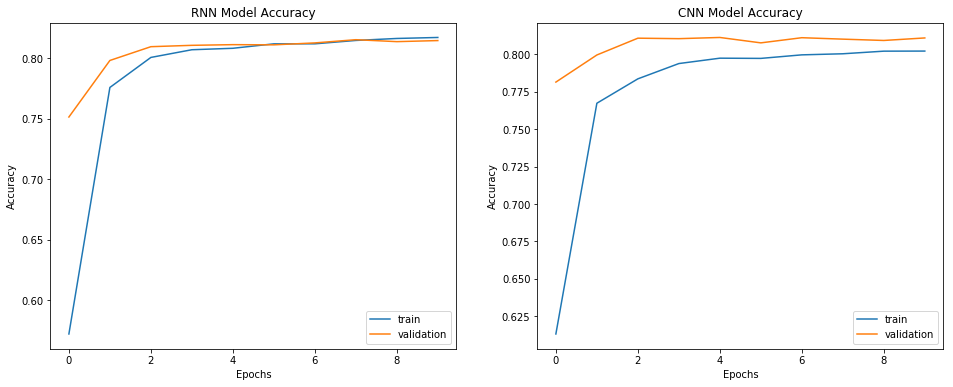

In [18]:
# Plot the results
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

From the above plot, we can see that both RNN and CNN models got a very decent performance. The test accuracy for both CNN and RNN is 81.5%.